In [61]:
import gzip
import pandas as pd
import json

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
%cd "/content/drive/MyDrive/DSPM"

/content/drive/MyDrive/DSPM


In [64]:
#import packages
import pandas as pd
import numpy as np
import re #regular expressions
# pip install -U spacy
# python -m spacy download en_core_web_sm
#pip install -U spacy && python -m spacy download en_core_web_sm
import spacy #natural language processing
import matplotlib.pyplot as plt
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize


In [65]:
#VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.  
 
#SentimentIntensityAnalyzer() is an object and polarity_scores is a method which will  give us scores of the following categories:
#· Positive
#· Negative
#· Neutral
#· Compound
  
#The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).
#The more Compound score closer to +1, the higher the positivity of the text.


In [66]:
#Read in the data
reviews = pd.read_json("top_prod_reviews.json",compression="gzip")
reviews.head(3)



,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
2543,1,0,A1SJGHZDQHVYWH,B000142FVW,Julie D. Cassetina,Doesnt match the regular color of the real pro...,One Star,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2544,3,0,A1EZAX4P346ABG,B000142FVW,James C. James,Not pigmented enough. Needed three coats and s...,Low pigment,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...
2545,4,0,A1AT61K23ZY13Z,B000142FVW,Amazon Customer,I really liked the color of this polish. It wa...,I really liked the color of this polish,['Nail lacquer is the original nail polish for...,,"OPI Nail Lacquer, Not So Bora-Bora-ing Pink, 0...","[B000NG90UM, B002D4GYHE, B00178VX50, B00R2X2S7...","26,115 in Beauty & Personal Care (","[B000NG801C, B004220DOU, B0035YFH6K, B006JUVPS...",$8.40,26115,'Nail lacquer is the original nail polish form...


In [67]:
#Focus on one product
prod3= reviews[reviews['asin']=="B00172O9NO"]
prod3.head(3)

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
173529,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,I love this facial mist by Mario Badescu! It's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173530,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,I use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
173531,5,0,ACXEUZEAZ276A,B00172O9NO,Amazon Customer,This beauty stays in my handbag to help rehydr...,this is just perfect. It refreshes my skin and...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."


In [68]:
#Reindex
prod3 = prod3.reset_index(drop=True)

In [69]:
#Turn the entire text into lowercase letters
prod3['reviewText']= prod3['reviewText'].apply(lambda x: x.lower())

In [70]:
prod3.head(2)

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc
0,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,i love this facial mist by mario badescu! it's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."
1,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,i use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ..."


In [71]:
#Tokenize the Data
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words.add("product")
nlp.Defaults.stop_words.add("products")
nlp.Defaults.stop_words.add("facial")
nlp.Defaults.stop_words.add("spray")
nlp.Defaults.stop_words.add("mist")
nlp.Defaults.stop_words.add("mario")
nlp.Defaults.stop_words.add("badescu")
nlp.Defaults.stop_words.add("skin")
nlp.Defaults.stop_words.add("makeup")

In [72]:
#Function to remove meaningless and stop words
def remove_stopwords(text):
  '''
  Args

  text : a string of product review

  Return:

  tokens: a string without stopwords and punctutaions
  '''
  tokens=[]
  doc=nlp(text)
  for word in doc:
    if word.is_stop==False:
      if word.is_punct==False:
        if word.pos_=='ADJ' or word.pos_=="NOUN" or word.pos_=="VERB":
          tokens.append(word.text)
  sentence = " ".join(tokens)

  
  return sentence

In [73]:
#Apply function to remove meaningless and stop words
prod3['reviewsTokens']=prod3['reviewText'].apply(lambda x: remove_stopwords(x))

In [74]:
prod3.head(3)

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc,reviewsTokens
0,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,i love this facial mist by mario badescu! it's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",love expect refreshing smells nice sprays purs...
1,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,i use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",use night setter day way wrong
2,5,0,ACXEUZEAZ276A,B00172O9NO,Amazon Customer,this beauty stays in my handbag to help rehydr...,this is just perfect. It refreshes my skin and...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",beauty stays handbag help rehydrate weather ai...


In [75]:
#what are the top 10 most frequent words
split_it = []
for i in prod3['reviewsTokens']:
    split_it+=i.split()

text_top_counter= Counter(split_it)
text_top= []
text_top_counts= []
for k, v in text_top_counter.most_common(10):
    text_top.append(k)
    text_top_counts.append(v)
print(text_top)

['love', 'face', 'use', 'smells', 'great', 'refreshing', 'good', 'smell', 'day', 'amazing']


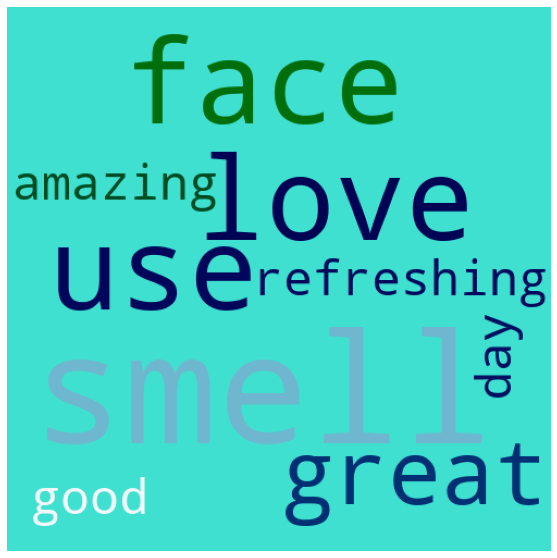

In [76]:
#Plot top 10 words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plot_it = " ".join(text_top)
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(plot_it)
plot_cloud(wordcloud)

In [77]:
# import Vader 
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [78]:
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
  
    # decide sentiment as positive and negative
    if sentiment_dict['compound'] >= 0.0 :
      result = "Positive"
  
    elif sentiment_dict['compound'] <  0.0 : 
      result = "Negative"
  
    return result

In [79]:
prod3.shape

(6126, 17)

In [80]:
# add verdict
def result_token(df):
  lst=[]
  for i in df['reviewsTokens']:
    output = sentiment_scores(i)
    lst.append(output)
  df['Verdict'] = lst
  return df

In [81]:
result_token(prod3)

,overall,vote,reviewerID,asin,reviewerName,reviewText,summary,description,fit,title,also_buy,rank,also_view,price,rank_amazon,desc,reviewsTokens,Verdict
0,5,23,A1FZMDMDM9D81Z,B00172O9NO,The Cat&#039;s Meow,i love this facial mist by mario badescu! it's...,Fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",love expect refreshing smells nice sprays purs...,Positive
1,5,0,A9U6XNKG8RYYI,B00172O9NO,Tise~,i use it as a facial spray at night and as a m...,I use it as a facial spray at night and ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",use night setter day way wrong,Negative
2,5,0,ACXEUZEAZ276A,B00172O9NO,Amazon Customer,this beauty stays in my handbag to help rehydr...,this is just perfect. It refreshes my skin and...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",beauty stays handbag help rehydrate weather ai...,Positive
3,5,0,A7SJJ5JNG94XS,B00172O9NO,Amazon Customer,love it! keep it in my bag and spritz myself t...,love it! keep it in my bag and spritz ...,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",love bag spritz day wear week keeps looking br...,Positive
4,5,0,A2TWZFOKWB0O29,B00172O9NO,Crystal Hernandez,can you say miracle for my skin my skin is ver...,Miracle for my skin,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",miracle dry places suffer incorporated current...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6121,5,0,A3MNM932X8LUNQ,B00172O9NO,Yoli R,cant wait to use it,Five Stars,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",wait use,Positive
6122,5,0,A1REBVJX3KOO2M,B00172O9NO,Savana,if you like facial spray mist and the smell of...,Smells so fresh!,"['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",like smell roses gorgeous smell goes light fac...,Positive
6123,3,0,A22I7X2QYUF6L8,B00172O9NO,Belle,"i bought this based on other reviews, i have s...","I bought this based on other reviews, I have ...","['A refreshing, hydrating mist to use anywhere...",,"Mario Badescu Facial Spray with Aloe, Herbs a...","[B0017SWIU4, B07BSV1T35, B0014P8L9W, B07DYDD49...",524 in Beauty & Personal Care (,"[B07849F4R5, B076XKLQ2T, B07G1493ZM, B00LBHEP3...",$12.00,524,"'A refreshing, hydrating mist to use anywhere ...",bought based reviews 

In [82]:
#choose 3 columns only

prod3 = prod3[['reviewText','overall','Verdict']]
prod3.head(5)


,reviewText,overall,Verdict
0,i love this facial mist by mario badescu! it's...,5,Positive
1,i use it as a facial spray at night and as a m...,5,Negative
2,this beauty stays in my handbag to help rehydr...,5,Positive
3,love it! keep it in my bag and spritz myself t...,5,Positive
4,can you say miracle for my skin my skin is ver...,5,Positive


In [83]:
#Turn into binary classification: Positive and Negative

change_nums = {"Verdict":     {"Positive": 1, "Negative": 0},
                "overall": {1: 0, 2: 0, 3: 0, 4: 1,5: 1}}
prod3 = prod3.replace(change_nums)
prod3.rename(columns = {'overall': 'sentiment','Verdict':'prediction'}, inplace = True)
prod3.head()



,reviewText,sentiment,prediction
0,i love this facial mist by mario badescu! it's...,1,1
1,i use it as a facial spray at night and as a m...,1,0
2,this beauty stays in my handbag to help rehydr...,1,1
3,love it! keep it in my bag and spritz myself t...,1,1
4,can you say miracle for my skin my skin is ver...,1,1


In [84]:
#Import evaluation packages
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

Random Chances: ROC AUC=0.500
Product 3: ROC AUC= 0.641
Product 3: Accuracy= 0.862
Product 3: Precision= 0.874
Product 3: Recall= 0.974
Product 3: f1= 0.922


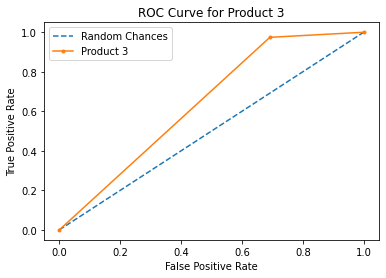

In [85]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(prod3['sentiment']))]

# calculate scores
ns_auc = roc_auc_score(prod3['sentiment'], ns_probs)
pro_1 = roc_auc_score(prod3['sentiment'], prod3['prediction'])
acc= accuracy_score(prod3['sentiment'],prod3['prediction'])
precision= precision_score(prod3['sentiment'],prod3['prediction'])
recall= recall_score(prod3['sentiment'],prod3['prediction'])
f1= f1_score(prod3['sentiment'],prod3['prediction'])


# summarize scores
print('Random Chances: ROC AUC=%.3f' % (ns_auc))
print('Product 3: ROC AUC= %.3f' % (pro_1))
print('Product 3: Accuracy= %.3f' % (acc))
print('Product 3: Precision= %.3f' % (precision))
print('Product 3: Recall= %.3f' % (recall))
print('Product 3: f1= %.3f' % (f1))



# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(prod3['sentiment'], ns_probs)
one_fpr, one_tpr, _ = roc_curve(prod3['sentiment'], prod3['prediction'])


# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Chances')
pyplot.plot(one_fpr, one_tpr, marker='.', label='Product 3')


# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.title("ROC Curve for Product 3")
# show the plot
pyplot.show()

In [86]:
# Grouped summary 
# Most reviews are predicted to be positive sentiments
prod3['prediction'].value_counts().to_frame()

,prediction
1,5677
0,449


In [ ]:
#Write output results to a txt file
output_file = open("Prod3.txt", "w")
output_file.write("{:.2f}\n".format(acc))
output_file.write("{:.2f}\n".format(precision))
output_file.write("{:.2f}\n".format(recall))
output_file.write("{:.2f}".format(f1))
output_file.close()

In [ ]:
#keeping the required dataset
prod3.to_json('prod3_Vader_predictions.json',compression='gzip')